# Regression Analysis: Horsepower & Electricity Consumption Prediction

In [46]:
# Common Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Common Utility Functions

## Model Training Function

In [47]:
def train_models(X_train, y_train, X_test, y_test):
    """
    Train 4 regression models: Linear, Polynomial (degree 2, 3, 4)

    Returns:
    - Dictionary with model names as keys and predictions as values
    """
    models = {}

    # Model 1: Linear Regression
    model_linear = LinearRegression()
    model_linear.fit(X_train, y_train)
    models['Linear Regression'] = {
        'y_pred_train': model_linear.predict(X_train),
        'y_pred_test': model_linear.predict(X_test)
    }

    # Model 2: Polynomial Regression (Degree 2)
    poly_features_2 = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly2 = poly_features_2.fit_transform(X_train)
    X_test_poly2 = poly_features_2.transform(X_test)
    model_poly2 = LinearRegression()
    model_poly2.fit(X_train_poly2, y_train)
    models['Polynomial (Degree 2)'] = {
        'y_pred_train': model_poly2.predict(X_train_poly2),
        'y_pred_test': model_poly2.predict(X_test_poly2)
    }

    # Model 3: Polynomial Regression (Degree 3)
    poly_features_3 = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly3 = poly_features_3.fit_transform(X_train)
    X_test_poly3 = poly_features_3.transform(X_test)
    model_poly3 = LinearRegression()
    model_poly3.fit(X_train_poly3, y_train)
    models['Polynomial (Degree 3)'] = {
        'y_pred_train': model_poly3.predict(X_train_poly3),
        'y_pred_test': model_poly3.predict(X_test_poly3)
    }

    # Model 4: Polynomial Regression (Degree 4)
    poly_features_4 = PolynomialFeatures(degree=4, include_bias=False)
    X_train_poly4 = poly_features_4.fit_transform(X_train)
    X_test_poly4 = poly_features_4.transform(X_test)
    model_poly4 = LinearRegression()
    model_poly4.fit(X_train_poly4, y_train)
    models['Polynomial (Degree 4)'] = {
        'y_pred_train': model_poly4.predict(X_train_poly4),
        'y_pred_test': model_poly4.predict(X_test_poly4)
    }

    return models

In [48]:
def evaluate_models(models, y_train, y_test, dataset_name=""):
    """
    Evaluate models and create results table

    Returns:
    - DataFrame with evaluation metrics
    """
    results = []

    for model_name, predictions in models.items():
        # Training metrics
        mse_train = mean_squared_error(y_train, predictions['y_pred_train'])
        mae_train = mean_absolute_error(y_train, predictions['y_pred_train'])
        r2_train = r2_score(y_train, predictions['y_pred_train'])

        # Test metrics
        mse_test = mean_squared_error(y_test, predictions['y_pred_test'])
        mae_test = mean_absolute_error(y_test, predictions['y_pred_test'])
        r2_test = r2_score(y_test, predictions['y_pred_test'])

        results.append({
            'Model': model_name,
            'MSE (Train)': round(mse_train, 4),
            'MAE (Train)': round(mae_train, 4),
            'R² (Train)': round(r2_train, 4),
            'MSE (Test)': round(mse_test, 4),
            'MAE (Test)': round(mae_test, 4),
            'R² (Test)': round(r2_test, 4)
        })

    results_df = pd.DataFrame(results)
    title = f"Evaluation Metrics for All Models"
    if dataset_name:
        title += f" ({dataset_name})"
    print(f"{title}:\n")
    print(results_df.to_string(index=False))

    return results_df

---

# Part 1: Horsepower Prediction

## 1. Loading the Dataset

Dataset: [Fuel Consumption Based on HP - Linear Regression](https://www.kaggle.com/datasets/ohiedulhaquemdasad/fuel-consumption-based-on-hp-linear-regression/data)

This dataset contains:
- **Horse Power**: Engine horsepower (feature)
- **Fuel Economy (MPG)**: Miles per gallon (target variable)

We'll predict Fuel Economy based on Horse Power using linear regression.

## 2. Data Inspection

In [49]:
# Load the dataset
df_hp = pd.read_csv('FuelEconomy.csv')

# Display first few rows
df_hp.head()

,Horse Power,Fuel Economy (MPG)
0,118.770799,29.344195
1,176.326567,24.695934
2,219.262465,23.952010
3,187.310009,23.384546
4,218.594340,23.426739


In [50]:
# Basic information about the dataset
print("Dataset Shape:", df_hp.shape)
print("\nColumn Names:")
print(df_hp.columns.tolist())
print("\nDataset Info:")
df_hp.info()
print("\nBasic Statistics:")
df_hp.describe()

Dataset Shape: (100, 2)

Column Names:
['Horse Power', 'Fuel Economy (MPG)']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Horse Power         100 non-null    float64
 1   Fuel Economy (MPG)  100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB

Basic Statistics:


,Horse Power,Fuel Economy (MPG)
count,100.000000,100.000000
mean,213.676190,23.178501
std,62.061726,4.701666
min,50.000000,10.000000
25%,174.996514,20.439516
50%,218.928402,23.143192
75%,251.706476,26.089933
max,350.000000,35.000000


In [51]:
# Check for missing values
print("Missing Values:")
missing_counts_hp = df_hp.isnull().sum()
print(missing_counts_hp)
print(f"\nTotal missing values: {missing_counts_hp.sum()}")
print("\nPercentage of missing values:")
print((missing_counts_hp / len(df_hp) * 100).round(2))

# Visualize missing values
if missing_counts_hp.sum() > 0:
    plt.figure(figsize=(8, 4))
    missing_counts_hp.plot(kind='bar')
    plt.title('Missing Values by Column')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No missing values found in the dataset!")

print("\nDuplicate Rows:", df_hp.duplicated().sum())

Missing Values:
Horse Power           0
Fuel Economy (MPG)    0
dtype: int64

Total missing values: 0

Percentage of missing values:
Horse Power           0.0
Fuel Economy (MPG)    0.0
dtype: float64

✓ No missing values found in the dataset!

Duplicate Rows: 0


In [52]:
## 3. Train-Test Split

In [53]:
# Prepare features and target
X_hp = df_hp[['Horse Power']]  # Features
y_hp = df_hp['Fuel Economy (MPG)']  # Target variable

# 70/30 train-test split
X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(X_hp, y_hp, test_size=0.3, random_state=42)

print(f"Training set size: {X_train_hp.shape[0]} ({X_train_hp.shape[0]/len(df_hp)*100:.1f}%)")
print(f"Test set size: {X_test_hp.shape[0]} ({X_test_hp.shape[0]/len(df_hp)*100:.1f}%)")

Training set size: 70 (70.0%)
Test set size: 30 (30.0%)


## 4. Model Training

We'll train 4 different regression models to predict Fuel Economy from Horse Power:

### Model Descriptions

**Model 1: Linear Regression**
- **Equation:** y = β₀ + β₁x
- **Description:** Fits a straight line to the data. The relationship between Horse Power and Fuel Economy is modeled as a linear function with one coefficient for the feature and an intercept term.

**Model 2: Polynomial Regression (Degree 2)**
- **Equation:** y = β₀ + β₁x + β₂x²
- **Description:** Fits a quadratic curve to the data. This allows for a curved relationship where the effect of Horse Power on Fuel Economy can change direction, capturing non-linear patterns with a single bend.

**Model 3: Polynomial Regression (Degree 3)**
- **Equation:** y = β₀ + β₁x + β₂x² + β₃x³
- **Description:** Fits a cubic curve with two bends, allowing for more complex non-linear relationships. This can capture S-shaped patterns and more intricate variations in how Horse Power affects Fuel Economy.

**Model 4: Polynomial Regression (Degree 4)**
- **Equation:** y = β₀ + β₁x + β₂x² + β₃x³ + β₄x⁴
- **Description:** Fits a quartic curve with three bends, providing maximum flexibility to capture highly complex non-linear patterns. This model can fit very intricate relationships but may be prone to overfitting with limited data.

In [54]:
# Train all models using the utility function
models_hp = train_models(X_train_hp, y_train_hp, X_test_hp, y_test_hp)

## 5. Evaluation Metrics

We'll evaluate each model using three key metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²).

### 5.1 Metric Descriptions

**Mean Squared Error (MSE):**
- **Formula:** MSE = (1/n) × Σ(yᵢ - ŷᵢ)²
- **Description:** Measures the average squared difference between predicted and actual values. It penalizes larger errors more heavily due to squaring. Lower values indicate better model performance. Units are squared (e.g., MPG²).

**Mean Absolute Error (MAE):**
- **Formula:** MAE = (1/n) × Σ|yᵢ - ŷᵢ|
- **Description:** Measures the average absolute difference between predicted and actual values. It treats all errors equally and is more interpretable than MSE since it's in the same units as the target variable (e.g., MPG). Lower values indicate better performance.

**R-squared (R²):**
- **Formula:** R² = 1 - (SS_res / SS_tot) where SS_res = Σ(yᵢ - ŷᵢ)² and SS_tot = Σ(yᵢ - ȳ)²
- **Description:** Measures the proportion of variance in the target variable explained by the model. Values range from -∞ to 1, where 1 indicates perfect predictions, 0 means the model performs as well as predicting the mean, and negative values indicate worse performance than the mean. Higher values indicate better model fit.

### 5.2 Practical Interpretation

**In the context of predicting Fuel Economy (MPG) from Horse Power:**

**Mean Absolute Error (MAE):**
- **What it means:** On average, how many MPG off is our prediction?
- **Example:** If MAE = 1.2 MPG, this means our model's predictions are typically off by about 1.2 miles per gallon. If a car actually gets 25 MPG, we might predict anywhere from 23.8 to 26.2 MPG on average.
- **Why it's useful:** Easy to understand - it's in the same units as what we're predicting. A car buyer can easily grasp "the model is usually within 1-2 MPG of the actual fuel economy."

**Mean Squared Error (MSE):**
- **What it means:** How much do large prediction errors hurt our model?
- **Example:** If MSE = 2.5 MPG², this tells us about the magnitude of errors, but it's harder to interpret directly. However, if we have two models and one has MSE = 2.0 and another has MSE = 3.0, the first is better.
- **Why it's useful:** Penalizes big mistakes more than small ones. If you're building a model for car manufacturers, you care more about avoiding predictions that are way off (like predicting 30 MPG when it's actually 20 MPG) than small errors. MSE helps identify models that avoid these large errors.

**R-squared (R²):**
- **What it means:** What percentage of the variation in fuel economy can we explain using horsepower?
- **Example:** If R² = 0.91 (or 91%), this means horsepower explains 91% of why different cars have different fuel economies. The remaining 9% is due to other factors (weight, aerodynamics, driving conditions, etc.).
- **Why it's useful:** Gives a sense of how well the model captures the relationship. An R² of 0.91 is excellent - it means horsepower is a very strong predictor. If R² was 0.50, it would mean horsepower only explains half the variation, suggesting other factors are equally important.

In [55]:
# Evaluate all models and create results table
results_df_hp = evaluate_models(models_hp, y_train_hp, y_test_hp, "Horsepower Prediction")

Evaluation Metrics for All Models (Horsepower Prediction):

                Model  MSE (Train)  MAE (Train)  R² (Train)  MSE (Test)  MAE (Test)  R² (Test)
    Linear Regression       2.1157       1.2100      0.9063      1.6749      1.0313     0.9133
Polynomial (Degree 2)       2.1151       1.2103      0.9063      1.6570      1.0254     0.9142
Polynomial (Degree 3)       2.0606       1.2115      0.9088      1.9037      1.0872     0.9015
Polynomial (Degree 4)       1.9177       1.1683      0.9151      2.5485      1.2034     0.8681


In [56]:
# Display formatted table
results_df_hp

,Model,MSE (Train),MAE (Train),R² (Train),MSE (Test),MAE (Test),R² (Test)
0,Linear Regression,2.1157,1.2100,0.9063,1.6749,1.0313,0.9133
1,Polynomial (Degree 2),2.1151,1.2103,0.9063,1.6570,1.0254,0.9142
2,Polynomial (Degree 3),2.0606,1.2115,0.9088,1.9037,1.0872,0.9015
3,Polynomial (Degree 4),1.9177,1.1683,0.9151,2.5485,1.2034,0.8681


## 6. Discussion

### Q. Which model performs best on the test set and why?
A. For this dataset, we only care about typical errors, and do not need to avoid large errors, meaning we need to prioritize MAE, which calculates the absolute error, over MSE, which calculates the squared error, leading to heavier penalization of larger errors. According to our evalulation metrics, the model that has the best (smallest) MAE is Polynomial (degree 2). This means that, on average, the model's predictions are wrong by 1.0254 MPG. The MSE for this test case is also the smallest among all, at 1.6570. Lastly, to verify the fact that this model performs the best, we turn our eyes towards the R^2 value. Polynomial (degree 2) has the highest R^2 value as well, meaning our model captures variations well. Since Polynomial (degree 2) outperforms all other models in all of these metrics, we can confidently say that it performs best on the test set.

### Q. Does increasing polynomial degree always improve performance? If not, explain what you observe.
A. In the context of this dataset, increasing the polynomial degree does not work in favor of overall model performance. As seen in our primary metric, MAE, the test MAE values get bigger as the degree of our polynomial, meaning that the average absolute error increases from 1.0250 MPG at degree 2 to 1.2034 MPG at degree 4. Similarly, MSE increases from 1.6570 MPG to 2.5485 MPG. Both of these increases imply that the model performance decreases. To reinforce this, we notice how the R^2 value also falls down as degree increases, meaning the model's ability to capture variance decreases.

### Q. If a model performs unexpectedly poorly (e.g., low R2 or large test error), propose at least two plausible reasons, such as:
- underfitting vs overfitting,
- weak relationship between features and target,
- outliers or noise in the data,
- insufficient feature information for predicting HP

One plausible reason is overfitting. In this dataset, higher-degree polynomial models (e.g., degree 3) show a noticeable increase in test MAE and MSE compared to their training errors. This gap indicates that the model is fitting noise or outliers in the training data rather than learning the underlying relationship. As a result, the model performs well on training data but generalizes poorly to unseen test data.

A second possible reason is the presence of outliers or noise in the dataset. Polynomial models with higher degrees are more sensitive to extreme values, which can cause the model to contort its curve to fit these points. This leads to increased prediction error on the test set and a reduction in R², as the model fails to capture the true data-generating trend.

Additionally, poor performance may stem from a weak relationship between the input features and the target variable (HP). If the available features do not contain sufficient information to accurately predict HP, even more complex models will struggle, resulting in low R² and large test errors regardless of model choice.

---

# Part 2: Electricity Consumption Prediction

## 1. Loading the Dataset

This dataset contains weather features and daily electricity consumption:
- **AWND**: Average daily wind speed (mph)
- **PRCP**: Precipitation (inches)
- **TMAX**: Maximum temperature (°F)
- **TMIN**: Minimum temperature (°F)
- **daily_consumption**: Daily electricity consumption (target variable)

We'll predict daily electricity consumption based on weather features.

In [57]:
# Load the electricity consumption dataset
df_electricity = pd.read_csv('electricity_consumption_based_weather_dataset.csv')

# Display first few rows
df_electricity.head()

,date,AWND,PRCP,TMAX,TMIN,daily_consumption
0,2006-12-16,2.5,0.0,10.6,5.0,1209.176
1,2006-12-17,2.6,0.0,13.3,5.6,3390.460
2,2006-12-18,2.4,0.0,15.0,6.7,2203.826
3,2006-12-19,2.4,0.0,7.2,2.2,1666.194
4,2006-12-20,2.4,0.0,7.2,1.1,2225.748


## 2. Data Inspection

In [58]:
# Basic information about the dataset
print("Dataset Shape:", df_electricity.shape)
print("\nColumn Names:")
print(df_electricity.columns.tolist())
print("\nDataset Info:")
df_electricity.info()
print("\nBasic Statistics:")
df_electricity.describe()

Dataset Shape: (1433, 6)

Column Names:
['date', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1433 non-null   object 
 1   AWND               1418 non-null   float64
 2   PRCP               1433 non-null   float64
 3   TMAX               1433 non-null   float64
 4   TMIN               1433 non-null   float64
 5   daily_consumption  1433 non-null   float64
dtypes: float64(5), object(1)
memory usage: 67.3+ KB

Basic Statistics:


,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1418.000000,1433.000000,1433.000000,1433.000000,1433.000000
mean,2.642313,3.800488,17.187509,9.141242,1561.078061
std,1.140021,10.973436,10.136415,9.028417,606.819667
min,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,1.800000,0.000000,8.900000,2.200000,1165.700000
50%,2.400000,0.000000,17.800000,9.400000,1542.650000
75%,3.300000,1.300000,26.100000,17.200000,1893.608000
max,10.200000,192.300000,39.400000,27.200000,4773.386000


Missing Values:
date                  0
AWND                 15
PRCP                  0
TMAX                  0
TMIN                  0
daily_consumption     0
dtype: int64

Total missing values: 15

Percentage of missing values:
date                 0.00
AWND                 1.05
PRCP                 0.00
TMAX                 0.00
TMIN                 0.00
daily_consumption    0.00
dtype: float64


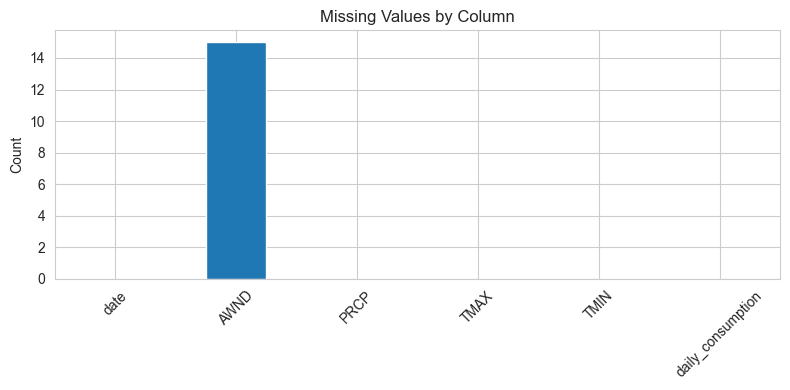


Duplicate Rows: 0


In [59]:
# Check for missing values
print("Missing Values:")
missing_counts_electricity = df_electricity.isnull().sum()
print(missing_counts_electricity)
print(f"\nTotal missing values: {missing_counts_electricity.sum()}")
print("\nPercentage of missing values:")
print((missing_counts_electricity / len(df_electricity) * 100).round(2))

# Visualize missing values
if missing_counts_electricity.sum() > 0:
    plt.figure(figsize=(8, 4))
    missing_counts_electricity.plot(kind='bar')
    plt.title('Missing Values by Column')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No missing values found in the dataset!")

print("\nDuplicate Rows:", df_electricity.duplicated().sum())

## 2.1 Handling Missing Values

In [60]:
# Handle missing values before train-test split
from sklearn.impute import SimpleImputer

# Check if there are missing values
if df_electricity.isnull().sum().sum() > 0:
    print("Handling missing values...")

    # For features: use mean imputation
    feature_cols = ['AWND', 'PRCP', 'TMAX', 'TMIN']
    imputer = SimpleImputer(strategy='mean')
    df_electricity[feature_cols] = imputer.fit_transform(df_electricity[feature_cols])

    # For target: drop rows with missing target values (critical for supervised learning)
    if df_electricity['daily_consumption'].isnull().sum() > 0:
        print(f"Dropping {df_electricity['daily_consumption'].isnull().sum()} rows with missing target values")
        df_electricity = df_electricity.dropna(subset=['daily_consumption'])

    print("Missing values handled!")
    print(f"Remaining missing values: {df_electricity.isnull().sum().sum()}")
else:
    print("No missing values to handle.")

Handling missing values...
Missing values handled!
Remaining missing values: 0


## 3. Train-Test Split

In [61]:
# Prepare features and target for electricity dataset
# Using weather features (excluding date)
X_electricity = df_electricity[['AWND', 'PRCP', 'TMAX', 'TMIN']]  # Features
y_electricity = df_electricity['daily_consumption']  # Target variable

# 70/30 train-test split
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_electricity, y_electricity, test_size=0.3, random_state=42)

print(f"Training set size: {X_train_e.shape[0]} ({X_train_e.shape[0]/len(df_electricity)*100:.1f}%)")
print(f"Test set size: {X_test_e.shape[0]} ({X_test_e.shape[0]/len(df_electricity)*100:.1f}%)")

Training set size: 1003 (70.0%)
Test set size: 430 (30.0%)


## 4. Model Training

We'll train 4 different regression models to predict daily electricity consumption from weather features:

### Model Descriptions

**Model 1: Linear Regression**
- **Equation:** y = β₀ + β₁x₁ + β₂x₂ + β₃x₃ + β₄x₄
- **Description:** Fits a linear hyperplane to the data. The relationship between weather features (wind, precipitation, max/min temperature) and electricity consumption is modeled as a linear combination of all features with an intercept term.

**Model 2: Polynomial Regression (Degree 2)**
- **Equation:** y = β₀ + Σβᵢxᵢ + Σβᵢⱼxᵢxⱼ
- **Description:** Fits a quadratic surface to the data. This allows for non-linear relationships and interactions between weather features, capturing how combinations of features (e.g., high temperature and high precipitation) affect electricity consumption.

**Model 3: Polynomial Regression (Degree 3)**
- **Equation:** y = β₀ + Σβᵢxᵢ + Σβᵢⱼxᵢxⱼ + Σβᵢⱼₖxᵢxⱼxₖ
- **Description:** Fits a cubic surface with more complex non-linear relationships. This can capture higher-order interactions between weather features and more intricate patterns in how weather conditions affect electricity consumption.

**Model 4: Polynomial Regression (Degree 4)**
- **Equation:** y = β₀ + Σβᵢxᵢ + Σβᵢⱼxᵢxⱼ + Σβᵢⱼₖxᵢxⱼxₖ + Σβᵢⱼₖₗxᵢxⱼxₖxₗ
- **Description:** Fits a quartic surface with maximum flexibility to capture highly complex non-linear patterns and high-order feature interactions. This model can fit very intricate relationships but may be prone to overfitting with limited data.

In [62]:
# Train all models using the utility function
models_electricity = train_models(X_train_e, y_train_e, X_test_e, y_test_e)

## 5. Evaluation Metrics

We'll evaluate each model using three key metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²).

### 5.1 Metric Descriptions

**Mean Squared Error (MSE):**
- **Formula:** MSE = (1/n) × Σ(yᵢ - ŷᵢ)²
- **Description:** Measures the average squared difference between predicted and actual values. It penalizes larger errors more heavily due to squaring. Lower values indicate better model performance. Units are squared (e.g., consumption²).

**Mean Absolute Error (MAE):**
- **Formula:** MAE = (1/n) × Σ|yᵢ - ŷᵢ|
- **Description:** Measures the average absolute difference between predicted and actual values. It treats all errors equally and is more interpretable than MSE since it's in the same units as the target variable (e.g., consumption units). Lower values indicate better performance.

**R-squared (R²):**
- **Formula:** R² = 1 - (SS_res / SS_tot) where SS_res = Σ(yᵢ - ŷᵢ)² and SS_tot = Σ(yᵢ - ȳ)²
- **Description:** Measures the proportion of variance in the target variable explained by the model. Values range from -∞ to 1, where 1 indicates perfect predictions, 0 means the model performs as well as predicting the mean, and negative values indicate worse performance than the mean. Higher values indicate better model fit.

### 5.2 Practical Interpretation

**In the context of predicting Daily Electricity Consumption from Weather Features:**

**Mean Absolute Error (MAE):**
- **What it means:** On average, how many consumption units off is our prediction?
- **Example:** If MAE = 200 units, this means our model's predictions are typically off by about 200 consumption units. If actual consumption is 1500 units, we might predict anywhere from 1300 to 1700 units on average.
- **Why it's useful:** Easy to understand - it's in the same units as what we're predicting. Energy managers can easily grasp "the model is usually within 200 units of the actual consumption."

**Mean Squared Error (MSE):**
- **What it means:** How much do large prediction errors hurt our model?
- **Example:** If MSE = 50000 units², this tells us about the magnitude of errors, but it's harder to interpret directly. However, if we have two models and one has MSE = 40000 and another has MSE = 60000, the first is better.
- **Why it's useful:** Penalizes big mistakes more than small ones. For energy grid management, avoiding predictions that are way off (like predicting 2000 units when it's actually 1000 units) is critical. MSE helps identify models that avoid these large errors.

**R-squared (R²):**
- **What it means:** What percentage of the variation in electricity consumption can we explain using weather features?
- **Example:** If R² = 0.75 (or 75%), this means weather features explain 75% of why different days have different electricity consumption. The remaining 25% is due to other factors (day of week, holidays, economic activity, etc.).
- **Why it's useful:** Gives a sense of how well the model captures the relationship. An R² of 0.75 is good - it means weather is a strong predictor. If R² was 0.30, it would mean weather only explains 30% of the variation, suggesting other factors are more important.

In [63]:
# Evaluate all models and create results table
results_df_electricity = evaluate_models(models_electricity, y_train_e, y_test_e, "Electricity Consumption")

Evaluation Metrics for All Models (Electricity Consumption):

                Model  MSE (Train)  MAE (Train)  R² (Train)  MSE (Test)  MAE (Test)  R² (Test)
    Linear Regression  274826.3121     387.0474      0.2729 237216.8887    365.5832     0.3115
Polynomial (Degree 2)  268041.4446     382.0871      0.2909 234831.8534    362.9045     0.3184
Polynomial (Degree 3)  261191.0805     377.7388      0.3090 238445.6415    369.0937     0.3079
Polynomial (Degree 4)  253602.6870     374.7296      0.3291 408466.1815    415.2872    -0.1855


In [64]:
# Display formatted table
results_df_electricity

,Model,MSE (Train),MAE (Train),R² (Train),MSE (Test),MAE (Test),R² (Test)
0,Linear Regression,274826.3121,387.0474,0.2729,237216.8887,365.5832,0.3115
1,Polynomial (Degree 2),268041.4446,382.0871,0.2909,234831.8534,362.9045,0.3184
2,Polynomial (Degree 3),261191.0805,377.7388,0.3090,238445.6415,369.0937,0.3079
3,Polynomial (Degree 4),253602.6870,374.7296,0.3291,408466.1815,415.2872,-0.1855


## 6. Discussion

### Q. Which model generalizes best (best test performance), and what does that tell you about the
relationship between weather and electricity usage?
A. The best test performance is for the model Polynomial (degree 2). This is proved by looking at the MSE and MAE values for all the models. While all of them are high, Polynomial (degree 2) has the lowest MSE and MAE values as compared to other models at 234831.8534 and 362.9045, respectively. This is reinforced by looking at the R^2 values, wherein Polynomial (degree 2) has the largest value (closest to 1) at 0.3184. This means that the model is the most robust, has the least large errors, and matches most of the variance, thus, it generalizes the best. However, the fact that the MSE and MAE values are so high, and R^2 is so low, means that there does not exist a relationship between weather and electricity usage that can be accurately captured using linear or polynomial regression.

### Q. Does increasing polynomial degree always improve performance? If not, explain what you observe.
A. No. As can be seen from the test MSE, MAE, and R^2 values, the MSE and MAE values increase as the polynomial degree becomes greater, and R^2 decreases as the degree increases. Thus, we can say that increasing the polynomial degree does not improve performance for this dataset.

### Q. If a model performs unexpectedly poorly (e.g., low R2 or large test error), propose at least two plausible reasons, such as:
- underfitting vs overfitting,
- weak relationship between features and target,
- outliers or noise in the data,
- insufficient feature information for predicting electricity consumption

A. An interesting phenomenon is also noticed for the Polynomial (degree 4) model. The train MSE, MAE, and R^2 values seem to be falling at a constant rate. However, this is not reflected in the test values for the same model, which seem like outliers, and are extremely skewed. This could be because the degree 4 polynomial model overfits the data. Meaning it learns the pattern of the training data well, leading to fairly consistent evaluation metric values. However, it is not able to generalize well for the test data. This could be because the training data has outliers or noise, which is what the model overfits to, leading to reduced performance.